# Clustering

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.cluster import KMeans
from sklearn import mixture
from scipy.stats import mode

In [2]:
# Load the PCA-transformed data
pca_df = pd.read_pickle('../data/time_series_experiment.pkl')
pca_df.head(5)

,timestamp,handTemperature,handAcc6_1,handAcc6_2,handAcc6_3,handGyro1,handGyro2,handGyro3,handMagne1,handMagne2,...,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4,subject_id
54744,0.000000,0.000000,0.416592,0.327858,0.358906,0.384091,0.312165,0.448252,0.331480,0.693147,...,0.450591,0.402609,0.584369,0.583772,0.675214,0.000000,0.410498,0.399328,0.382584,0.000000
440445,0.000010,0.657134,0.426800,0.372303,0.389116,0.384861,0.315870,0.447724,0.380052,0.460199,...,0.450329,0.402836,0.375367,0.435081,0.416811,0.406998,0.410498,0.399328,0.382584,0.693147
238954,0.000013,0.657134,0.426689,0.366632,0.389774,0.382324,0.312644,0.447637,0.384266,0.461290,...,0.448600,0.402408,0.382932,0.433296,0.418564,0.406998,0.410498,0.399328,0.382584,0.693147
22854,0.000015,0.657134,0.426412,0.365362,0.390019,0.382412,0.313817,0.447756,0.378250,0.463590,...,0.449696,0.402903,0.379595,0.433897,0.420464,0.406998,0.410498,0.399328,0.382584,0.693147
366131,0.000020,0.657134,0.426417,0.365430,0.390581,0.383862,0.316482,0.447812,0.381315,0.463869,...,0.447368,0.402765,0.379580,0.434872,0.419858,0.406998,0.410498,0.399328,0.382584,0.693147


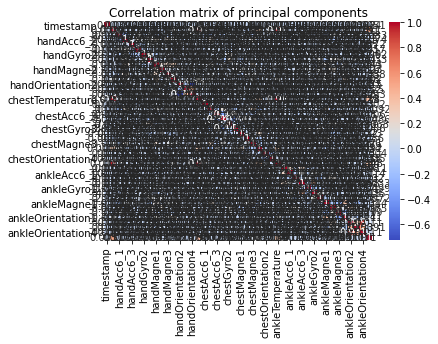

In [3]:
# Plot correlation matrix of principal components
corr_matrix = pca_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation matrix of principal components')
plt.show()

### KMeans

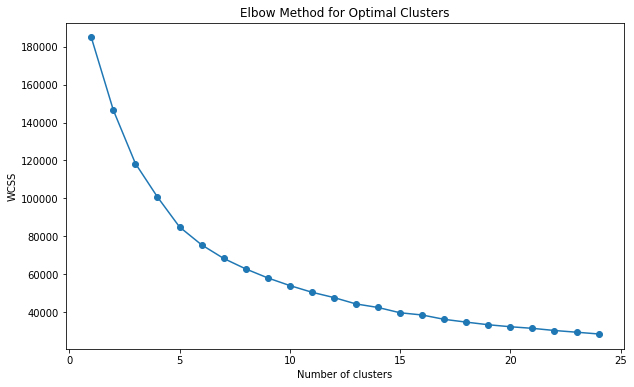

In [10]:
# Determine the optimal number of clusters using the Elbow Method
wcss = []  # Within-cluster sum of squares
for i in range(1, 25):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(pca_df)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 25), wcss, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [18]:
# Helper function to get Betweenss (inter-cluster distance)
def get_betweenss(cluster_model):
    betweenss = 0
    overall_mean = np.mean(pca_df, axis=0)
    for i in range(cluster_model.n_clusters):
        cluster_points = pca_df[cluster_model.labels_ == i]
        cluster_mean = np.mean(cluster_points, axis=0)
        cluster_size = len(cluster_points)
        betweenss += cluster_size * np.sum((cluster_mean - overall_mean) ** 2)
    return betweenss


In [19]:
# Calculate cohesion (the lower the better) and separation (the higher the better)
def get_cohesion_and_separation(cluster_model):
    betweenss = get_betweenss(cluster_model)
    withinss = cluster_model.inertia_
    return [withinss/(betweenss + withinss), betweenss/(betweenss + withinss)]

In [20]:
# Allow model comparison with different K values
def compare_models(k_list):
    model_list = []
    for k in k_list:
        kmeans = KMeans(n_clusters=k, random_state=42).fit(pca_df)
        cohesion, separation = get_cohesion_and_separation(kmeans)
        print(f"K = {k}, Cohesion = {round(cohesion, 3)}, Separation = {round(separation, 3)}")
        model_list.append(kmeans)
    return model_list

compare_models([5, 10, 15, 20, 25, 30])


K = 5, Cohesion = 0.661, Separation = 0.339
K = 10, Cohesion = 0.535, Separation = 0.465
K = 15, Cohesion = 0.469, Separation = 0.531
K = 20, Cohesion = 0.418, Separation = 0.582
K = 25, Cohesion = 0.386, Separation = 0.614
K = 30, Cohesion = 0.359, Separation = 0.641


[KMeans(n_clusters=5, random_state=42),
 KMeans(n_clusters=10, random_state=42),
 KMeans(n_clusters=15, random_state=42),
 KMeans(n_clusters=20, random_state=42),
 KMeans(n_clusters=25, random_state=42),
 KMeans(n_clusters=30, random_state=42)]

In [4]:
# Get baseline model and labeled data
kmeans = KMeans(n_clusters=4, random_state=42).fit(pca_df)
kmeans_labeled = pca_df.assign(label=kmeans.labels_)
kmeans_labeled.head(5)

,timestamp,handTemperature,handAcc6_1,handAcc6_2,handAcc6_3,handGyro1,handGyro2,handGyro3,handMagne1,handMagne2,...,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4,subject_id,label
54744,0.000000,0.000000,0.416592,0.327858,0.358906,0.384091,0.312165,0.448252,0.331480,0.693147,...,0.402609,0.584369,0.583772,0.675214,0.000000,0.410498,0.399328,0.382584,0.000000,3
440445,0.000010,0.657134,0.426800,0.372303,0.389116,0.384861,0.315870,0.447724,0.380052,0.460199,...,0.402836,0.375367,0.435081,0.416811,0.406998,0.410498,0.399328,0.382584,0.693147,3
238954,0.000013,0.657134,0.426689,0.366632,0.389774,0.382324,0.312644,0.447637,0.384266,0.461290,...,0.402408,0.382932,0.433296,0.418564,0.406998,0.410498,0.399328,0.382584,0.693147,3
22854,0.000015,0.657134,0.426412,0.365362,0.390019,0.382412,0.313817,0.447756,0.378250,0.463590,...,0.402903,0.379595,0.433897,0.420464,0.406998,0.410498,0.399328,0.382584,0.693147,3
366131,0.000020,0.657134,0.426417,0.365430,0.390581,0.383862,0.316482,0.447812,0.381315,0.463869,...,0.402765,0.379580,0.434872,0.419858,0.406998,0.410498,0.399328,0.382584,0.693147,3


### GMM

In [4]:
gmm = mixture.GaussianMixture(n_components=4, covariance_type='full', n_init=100).fit(pca_df)
gmm_labeled = pca_df.assign(label=gmm.predict(pca_df))
gmm_labeled.head(5)
print(f"The random state of the model is {gmm.random_state}")

The random state of the model is None


### Baseline Model Kaggle Submission

In [10]:
# Reorder the laebl and format output for kaggle submission
def format_submission(df, label_col = "label"):
    df = df.sort_index()
    df = pd.DataFrame(df[label_col])
    label_mapping = {}
    activtyID_list = []
    raw_label = df[label_col].tolist()
    for l in raw_label:
        if len(label_mapping) == 0:
            label_mapping[l] = 1 # Final label starts with 1
            activtyID_list.append(1)
        elif l not in label_mapping:
            label_mapping[l] = max(list(label_mapping.values())) + 1
            activtyID_list.append(label_mapping[l])
        else:
            activtyID_list.append(label_mapping[l])
    df["activityID"] = activtyID_list
    print(df)
    df.drop(label_col, axis=1, inplace=True)
    df.to_csv("../data/submission.csv", index=True, index_label=["Index"])

In [11]:
format_submission(kmeans_labeled)

        label  activityID
0           3           1
1           0           2
2           1           3
3           0           2
4           3           1
...       ...         ...
534596      0           2
534597      2           4
534598      2           4
534599      0           2
534600      1           3

[534601 rows x 2 columns]


### Bagging Kmeans

In [52]:
n_clusters = 4
n_bagging_iterations = 15

# Initialize result array
all_labels = np.zeros((pca_df.shape[0], n_bagging_iterations))

for i in range(n_bagging_iterations):
    # Construct the single kmeans model
    pca_df_resampled = resample(pca_df, replace=True, n_samples=round(0.5 * pca_df.shape[0]), random_state=i)
    kmeans = KMeans(n_clusters=n_clusters, random_state=i)
    kmeans.fit(pca_df_resampled)
    raw_label = kmeans.predict(pca_df)
    label_mapping = {}
    activtyID_list = []
    # Reorder label to make it consistent across different interations
    for l in raw_label:
        if len(label_mapping) == 0:
            label_mapping[l] = 1 # Final label starts with 1
            activtyID_list.append(1)
        elif l not in label_mapping:
            label_mapping[l] = max(list(label_mapping.values())) + 1
            activtyID_list.append(label_mapping[l])
        else:
            activtyID_list.append(label_mapping[l])
    all_labels[:, i] = activtyID_list

# Find the consensus label
consensus_labels = np.apply_along_axis(lambda x: np.bincount(x.astype(int)).argmax(), axis=1, arr=all_labels)

In [53]:
submission_df = pd.DataFrame(consensus_labels, index=range(len(pca_df)), columns=["activityID"])
submission_df.to_csv("../data/submission_bagged.csv", index=True, index_label=["Index"])

### Boosting Kmeans

In [57]:
n_clusters = 4
n_boosting_iterations = 15
sample_weights = np.ones(pca_df.shape[0])
all_labels = np.zeros((pca_df.shape[0], n_boosting_iterations))

for i in range(n_boosting_iterations):
    # Construct the single kmeans model
    kmeans = KMeans(n_clusters=n_clusters, random_state=i)
    kmeans.fit(pca_df, sample_weight=sample_weights) # cluster based on the weight of data 
    labels = kmeans.predict(pca_df)
    label_mapping = {}
    activtyID_list = []
    # Reorder the label to make it consistent across iteration
    for l in raw_label:
        if len(label_mapping) == 0:
            label_mapping[l] = 1 # Final label starts with 1
            activtyID_list.append(1)
        elif l not in label_mapping:
            label_mapping[l] = max(list(label_mapping.values())) + 1
            activtyID_list.append(label_mapping[l])
        else:
            activtyID_list.append(label_mapping[l])
    all_labels[:, i] = activtyID_list
    # Update sample weights based on consistency
    for j in range(pca_df.shape[0]):
        # Increase weight for points that were inconsistently clustered
        if np.sum(all_labels[j, :i+1] == mode(all_labels[j, :i+1]).mode[0]) < (i + 1) / 2:
            sample_weights[j] *= 1.1

sample_weights /= np.sum(sample_weights)
consensus_labels = mode(all_labels, axis=1).mode.flatten()

In [66]:
submission_df = pd.DataFrame(consensus_labels, index=range(len(pca_df)), columns=["activityID"])
submission_df["activityID"] = submission_df["activityID"].astype(int)
submission_df.to_csv("../data/submission_boosted.csv", index=True, index_label=["Index"])